# Cycle Life Prediction Tutorial
This notebook overviews concepts for battery cycle life prediction. Much of the feature engineering as well as the cycling dataset was introduced by [Severson et al.](https://web.mit.edu/braatzgroup/Severson_NatureEnergy_2019.pdf) in their 2019 Nature Energy publication. 

Our ML goal is to train a model which can predict the number of cycles a cell will be able to cycle before reaching a specified capacity retention threshold. In this example, we will be using an 85% capacity retention threshold, as referenced from cycle 20. 

The segments of this tutorial are as follows:
1. [Load dataset and perform exploratory data analysis](#Exploratory-Data-Analysis)
1. [Model initialization and training](#Model-Initialization-and-Training)
1. [Model testing and evaluation](#Model-Testing-and-Evaluation)
1. [Prediction of cycle life on unseen data](#Prediction-of-Cycle-Life-on-Unseen-Data)

Here is what the cycling performance of the Severson dataset looks like (taken from the manuscript)
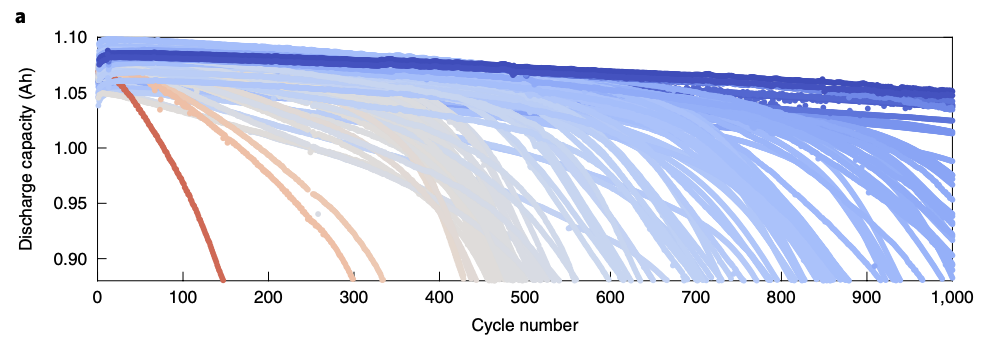

In [75]:
import voltaiq_studio as vs
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Structure of this script:
1. Discussion of the goal of the script/algorithm that we will be training
1. Load in the featurized dataset - X (all the features of the discharge dataset) and y (cycle life) for the Severson dataset. Note to the audience that we will be using the same dataset as for anomaly detection
1. A little bit of explanation on feature engineering - reference the Severson paper
    **NEED TO START WITH THIS SECTION - PLOT OF THE DISCHARGE CAPACITY VS VOLTAGE DATA FROM THE PAPER, AS WELL AS SOME OF THE OTHER FEATURES THAT WE MIGHT BE INTERESTED IN
    COULD HAVE USERS LIST/SUGGEST SOME FEATURES THAT THEY MIGHT WANT TO EXPLORE LATER. WHAT DO THEY THINK MIGHT BE IMPORTANT FOR CYCLE LIFE PREDICTION?**
1. Exploratory data analysis:
    - make a plot of the histogram of cycle lives for the dataset (can do it for the total as well as on a batch-level)
    - plot the pearson correlation of the variance feature, as well as 2 other features
    - anything else to do here? probably don't have too much time...
1. Definition of models that we might want to look at for regression
    - start with the Severson enetCV (linear regression)
    - maybe add in one more, just for something different?
1. train model(s)
1. model evaluation:
    - MAPE
    - RMSE
    - parity plots
1. do I want to choose a model? and then see how it would perform on the evaluation dataset?
1. test models on the test dataset
1. load some prediction datasets and try to predict the cycle life on those - how do they perform?
    - discussion point: why might some datasets perform worse? go back to the feature distributions and see whether they match up or are very different
    - filter out for some datasets vs others
    - it's really important to think critically about what questions you are trying to answer? There is a lot of metadata that we didn't consider here - cycling profiles, chemistry, etc. This is all important and we need to determine whether we are trying to interpolate or extrapolate, predict or explain, etc...


how to make it interactive???
- could think about different features to add
- could think about different models to try

need to figure out:
1. how I want to portray the data cycle life
1. whether I want to provide actual interactivity

## Exploratory Data Analysis
In this section, we will load in the Severson dataset, discuss some of the feature engineering, and perform initial exploratory data analysis (EDA). To speed up the analysis in this script, we will load the feature-engineered dataset from the Showcase directly. This dataframe contains a set of possible features that we might want to use to predict cycle life, as well as the actual cycle life of each of the tests. 

The dataset also contains a few `Dataset_group`s - we will use these to split the data into various train/test combinations. At the start, we will assume that we only have the training dataset, labeled `Severson2019 - Train (LFP)`.

In [46]:
load_name = 'dataset2022-12-05 14_53_30.896552'
with open(load_name, "rb") as f:
    data = pickle.load(f)

Let's take a look at the dataset

In [47]:
data.head()

,min_deltaQ,mean_deltaQ,var_deltaQ,skew_deltaQ,kur_deltaQ,deltaQ_lowV,slope_22_99,intcpt_22_99,slope_90_99,intcpt_90_99,q_22,maxQ_q_22,q_99,Dataset_group,cyc_life
Name,,,,,,,,,,,,,,,
2017-05-12_3_6C-80per_3_6C_CH2_VDF,-2.070144,-2.455492,-5.028018,-0.427786,-1.869674,-0.002186,-0.000017,1.082534,-0.000029,1.083580,1.081923,0.608978,1.080649,Severson2019 - Train (LFP),2055.0
2017-05-12_4C-80per_4C_CH5_VDF,-1.840401,-2.218537,-4.632537,-0.526915,0.097271,-0.002521,-0.000007,1.085825,-0.000007,1.085408,1.085078,0.007000,1.084765,Severson2019 - Train (LFP),1336.0
2017-05-12_4_4C-80per_4_4C_CH7_VDF,-1.657452,-2.032932,-4.293405,-0.725104,0.064739,-0.004419,-0.000011,1.081323,-0.000024,1.082180,1.080456,0.001615,1.079788,Severson2019 - Train (LFP),1037.0
2017-05-12_4_8C-80per_4_8C_CH9_VDF,-1.547026,-1.950946,-4.041558,-0.335869,0.064054,-0.003491,-0.000024,1.098508,-0.000033,1.099141,1.096267,0.001701,1.095874,Severson2019 - Train (LFP),817.0
2017-05-12_5_4C-50per_3C_CH14_VDF,-1.589375,-2.030320,-4.108288,-0.228045,0.051376,-0.003403,-0.000008,1.061089,-0.000014,1.061318,1.060326,0.002914,1.059947,Severson2019 - Train (LFP),766.0


There are a few different `Dataset_group`s:

In [48]:
print(list(pd.unique(data.Dataset_group)))

['Severson2019 - Train (LFP)', 'Severson2019 - Test (LFP)', 'Severson2019 - Test2 (LFP)', 'Attia2020 (LFP)', 'Weng2021 (NMC)']


### Split training data
Let's start by only looking at the training dataset: `Severson2019 - Train (LFP)`. It is generally best practice to perform your data split (into training and testing) at the outset, BEFORE you begin to explore the characteristics of your dataset. This ensures that you do not have any information leakage between your training dataset and the data on which you are trying to test the performance of your model.

In [53]:
train_data = data[data.Dataset_group == 'Severson2019 - Train (LFP)'].copy()

In [54]:
print('Length training data: ', len(train_data))
print('Total dataset length: ', len(data))

Length training data:  41
Total dataset length:  209


The target (dependent variable) that we are looking to predict is the cycle life, given by `cyc_life`

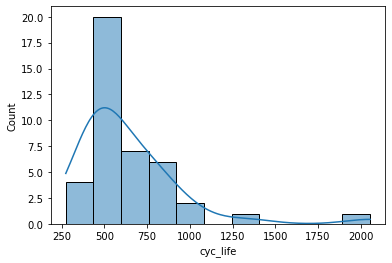

In [55]:
_ = sns.histplot(data = train_data, x = 'cyc_life', kde=True)

We can see that the cycle life has a pretty long tail, with many more tests at lower cycle lives. To try to correct for that skewed distribution, we will transform the target variable using a logarithm. This is a common transformation when the data is highly non-Gaussian.

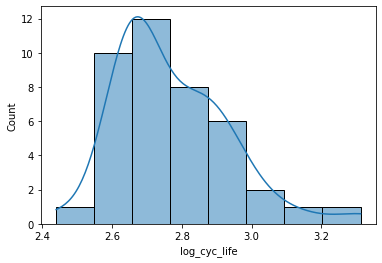

In [56]:
train_data['log_cyc_life'] = np.log10(train_data.cyc_life)
_ = sns.histplot(data = train_data, x = 'log_cyc_life', kde=True)

### Feature exploration
We would like to also explore the distributions and correlations of a few of the features that have been calculated for this dataset. While in this tutorial the features have been pre-calculated, based on the features suggested by Severson et al., in reality this feature engineering step will be one of the most important, as in the case with Anomaly Detection.

Let us first define a few of the features in more detail:

#### 1. deltaQ
There are a few features that have been calculated as statistics based on a variable called `deltaQ`. This deltaQ variable is the difference between the voltage vs discharge capacity curves for two cycles. In the original study, cycles 10 and 100 were chosen. For this tutorial we have chosen cycles 20 and 99 - this was done because we will be looking at another public dataset for which those cycles made more sense. The general concepts and outcomes are the same as in the original Severson study, however.

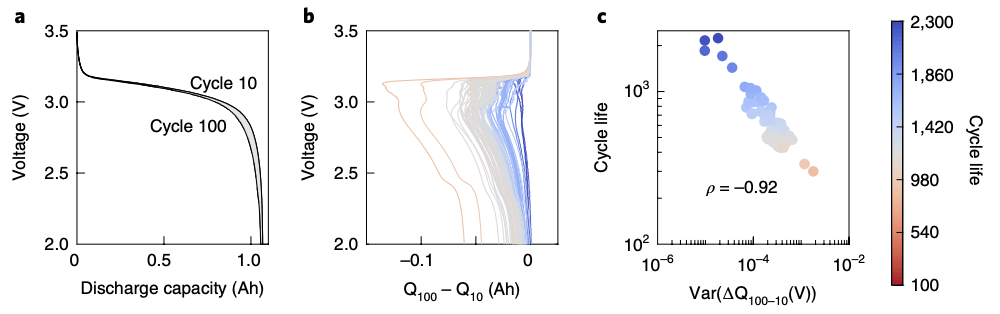

A few statistical features were calculated based on the deltaQ variable. These include the:
1. min
1. mean
1. variance
1. skew
1. kurtosis

As can be seen in part (c) of the figure above, the variance is highly correlated with the final cycle life performance of the cells.

#### 2. deltaQ_lowV
This feature is also derived from the deltaQ variable, but in this case represents the difference in discharge capacity at the lower cutoff voltage of the two cycles in question. This feature is less information rich than the statistical features above, since only a single voltage point is taken for the comparison/calculation.

#### 3. Slope/intercept of discharge capacity vs cycle # data
There are a few features that are calculated based on solely the discharge capacity vs cycle # data. These include a subset of features that detail a linear fit between the discharge capacity vs cycle # for specific cycles. A line was fit between the 22nd and 99th cycles as well as between the 90th and 99th cycles, and the slope and intercept were captured as features. These provide information on the *linear* rate of decay between these two cycles.
1. slope_22_99
1. intcpt_22_99
1. slope_90_99
1. intcpt_90_99

#### 4. Discharge capacity values
Lastly, a few features were built based on the raw discharge capacity values. These include the discharge capacity values for cycles 22 and 99, as well as the difference between the maximum discharge capacity value and the value at cycle 22.
1. q_22
1. q_99
1. maxQ_q_22

We will start by looking at the correlation between features using a pairplot. This provides us with information on the visual correlation between each variable and every other variable - this enables us to visually identify whether any of the independent features that we have calculated are (1) correlated strongly with other features and (2) correlated strongly with our target variable.

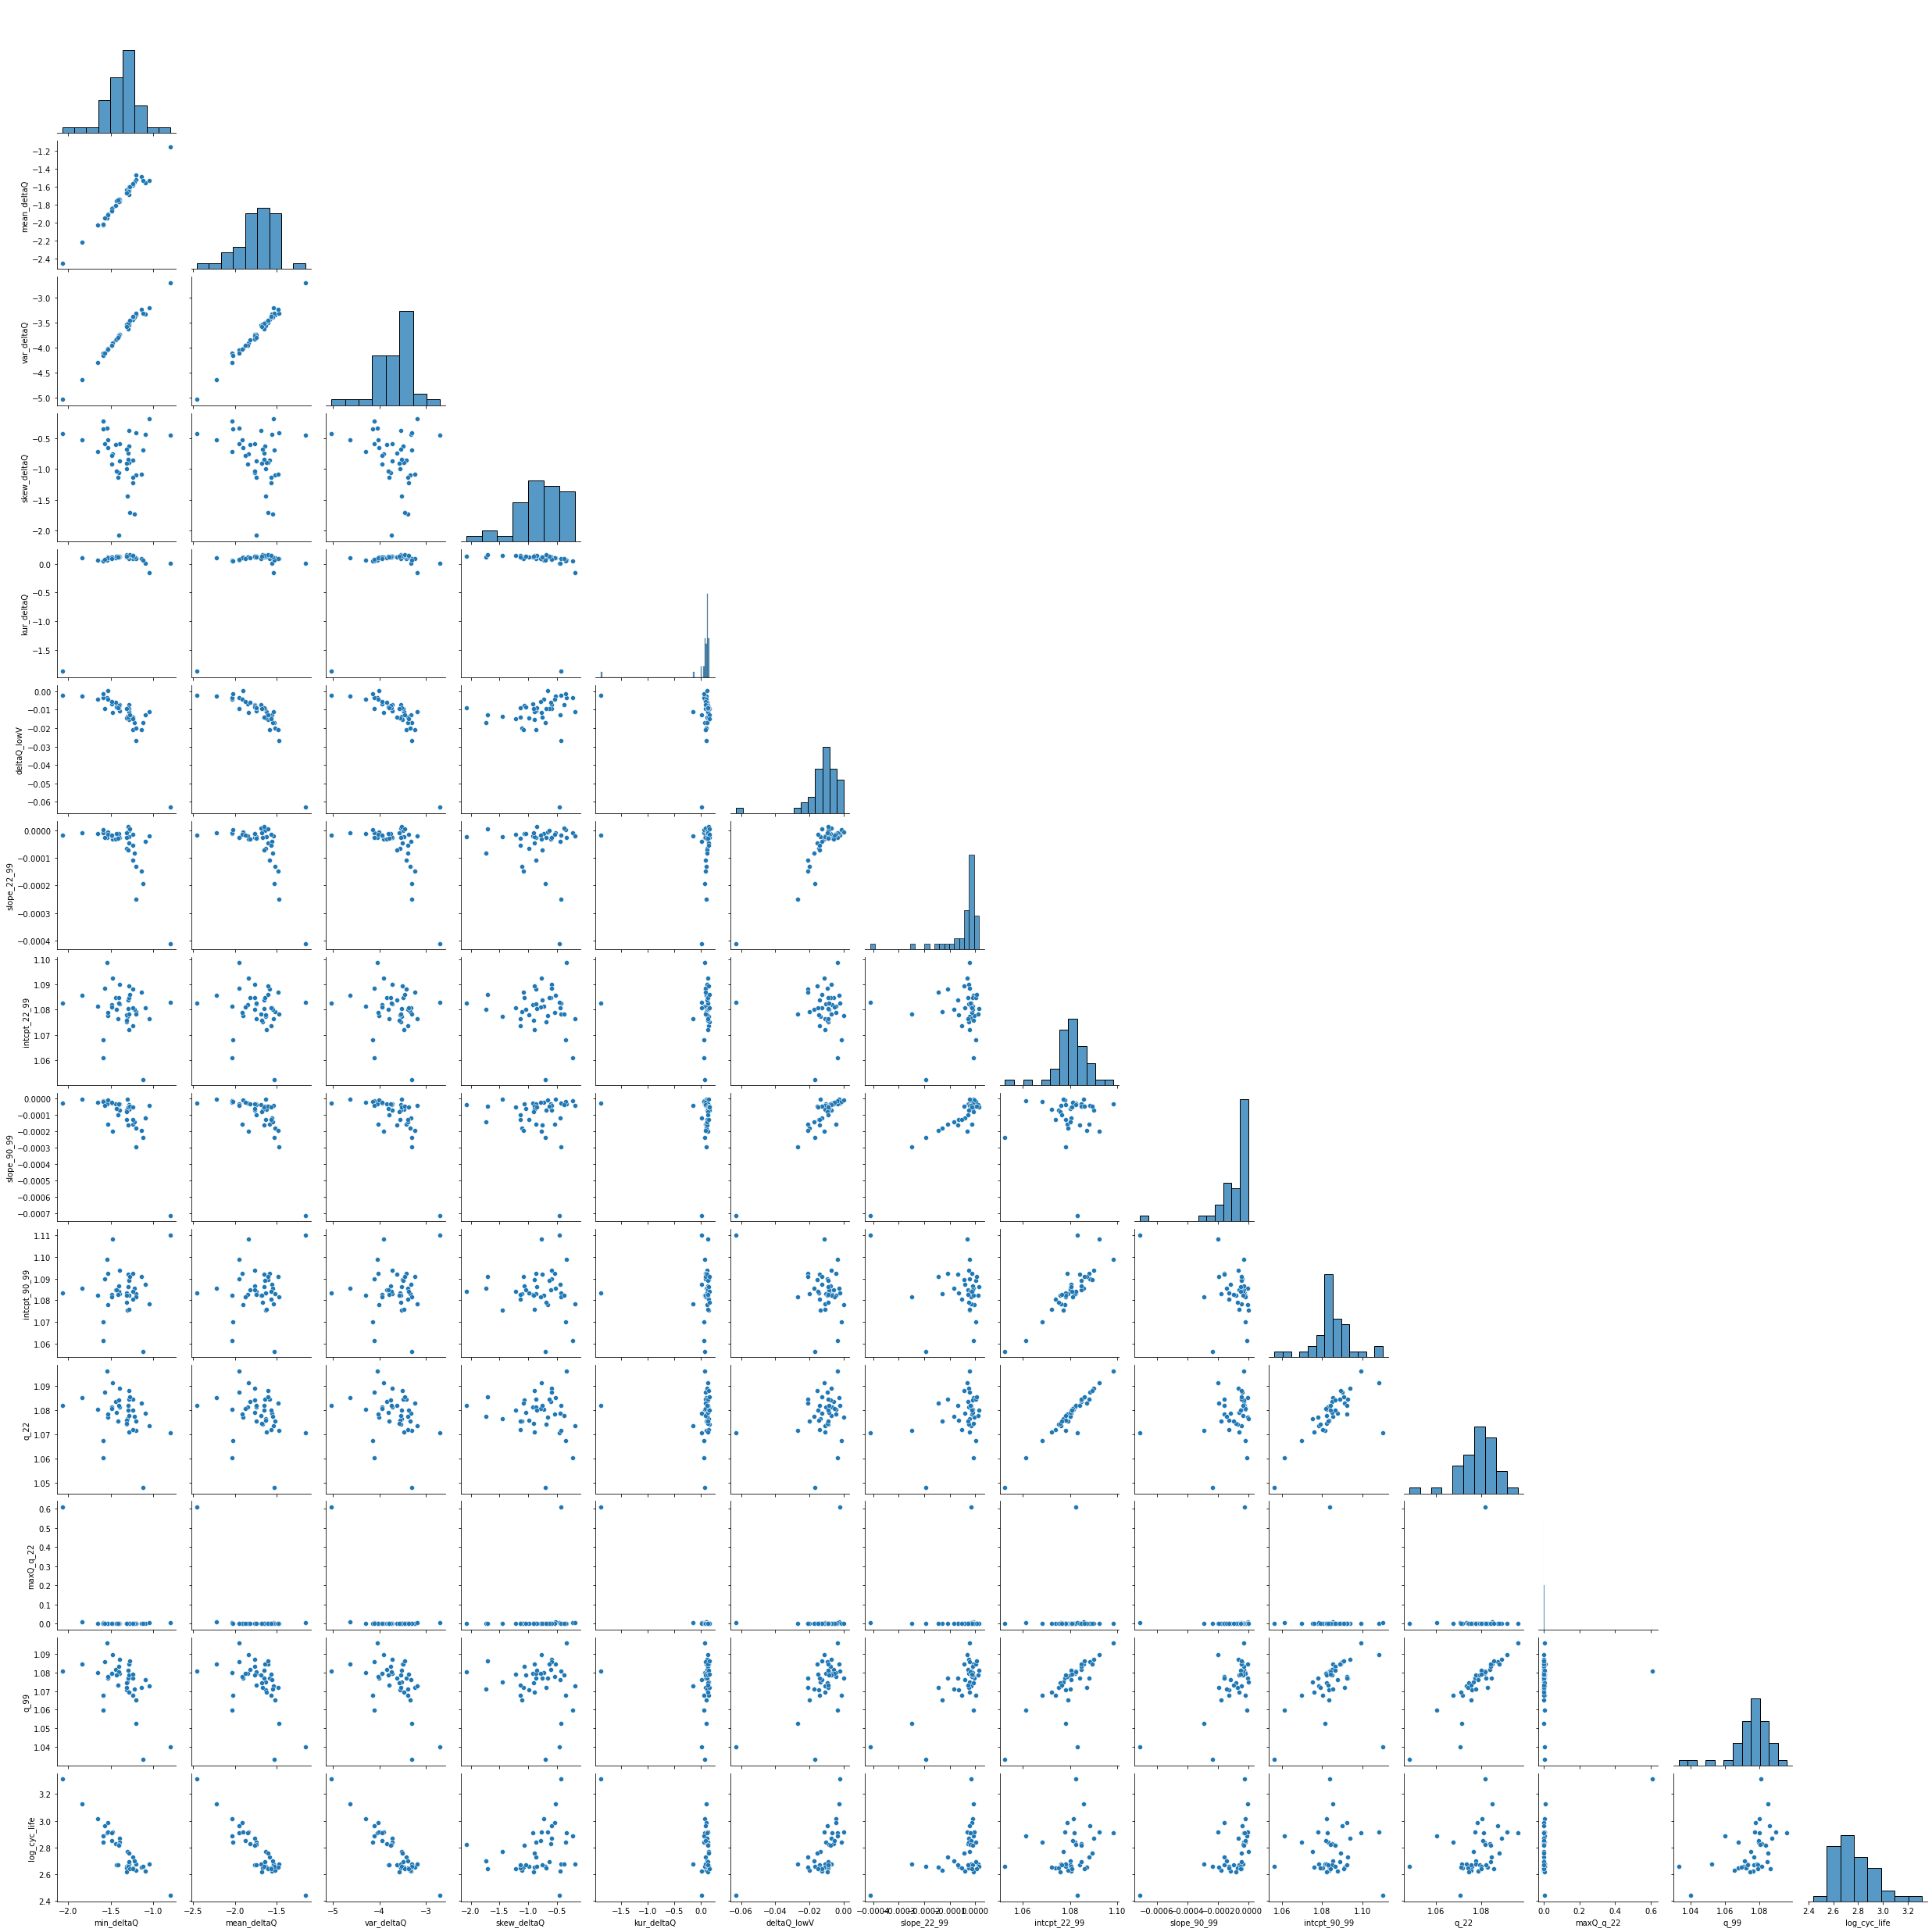

In [58]:
_ = sns.pairplot(data = train_data.drop(columns = ['cyc_life']),corner=True)

For this dataset, a few variables seeem to be highly correlated. These include:
1. Min, Mean and Var deltaQ
1. q_22 and intcpt_22_99

If we want to be more quantitative about the correlations, we can instead create a heatmap, as shown below. Both the very light and very dark squares are highly correlated (either positively or negatively).

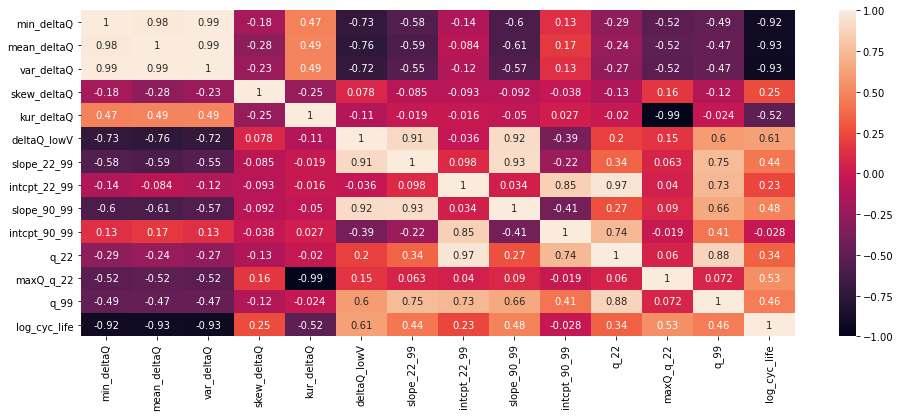

In [61]:
plt.figure(figsize=(16, 6))
_ = sns.heatmap(train_data.drop(columns = ['cyc_life']).corr(), vmin=-1, vmax=1, annot=True)

Notice that sometimes the heatmap shows strong correlations when in reality based on the scatter plot it's likely there are perhaps just some outliers in our dataset. This is the case for maxQ_q_22 and kur_deltaQ, for example.

## Model Initialization and Training
Once we have a set of **Features** that we think might be useful for predicting cycle life as well as our **Target** variable, in this case the **log cycle life**, we can begin to initialize some possible machine learning models and train them.

In this section, we will discuss a simple **linear regression** machine learning model - an [Elastic Net model, with cross-validation](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net). We will be relying on [Scikit-Learn's implementation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html) of this model.

The motivation for using an Elastic Net model is that it works to help minimize *overfitting* by limiting either the *number of features* or the *importance of the features* that it uses to train. Elastic-net is useful when there are multiple features that are correlated with one another (which we saw is the case). 

**Overfitting** means that a model fits the training data extremely well, but will not appropriately predict new datapoints, even if these datapoints exist within the same region as the training dataset. This is in contrast to **underfitting** which creates models that are too simple and do not capture the actual behavior of the data. This can be visualized in this graphic by [Scikit-Learn](https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html).

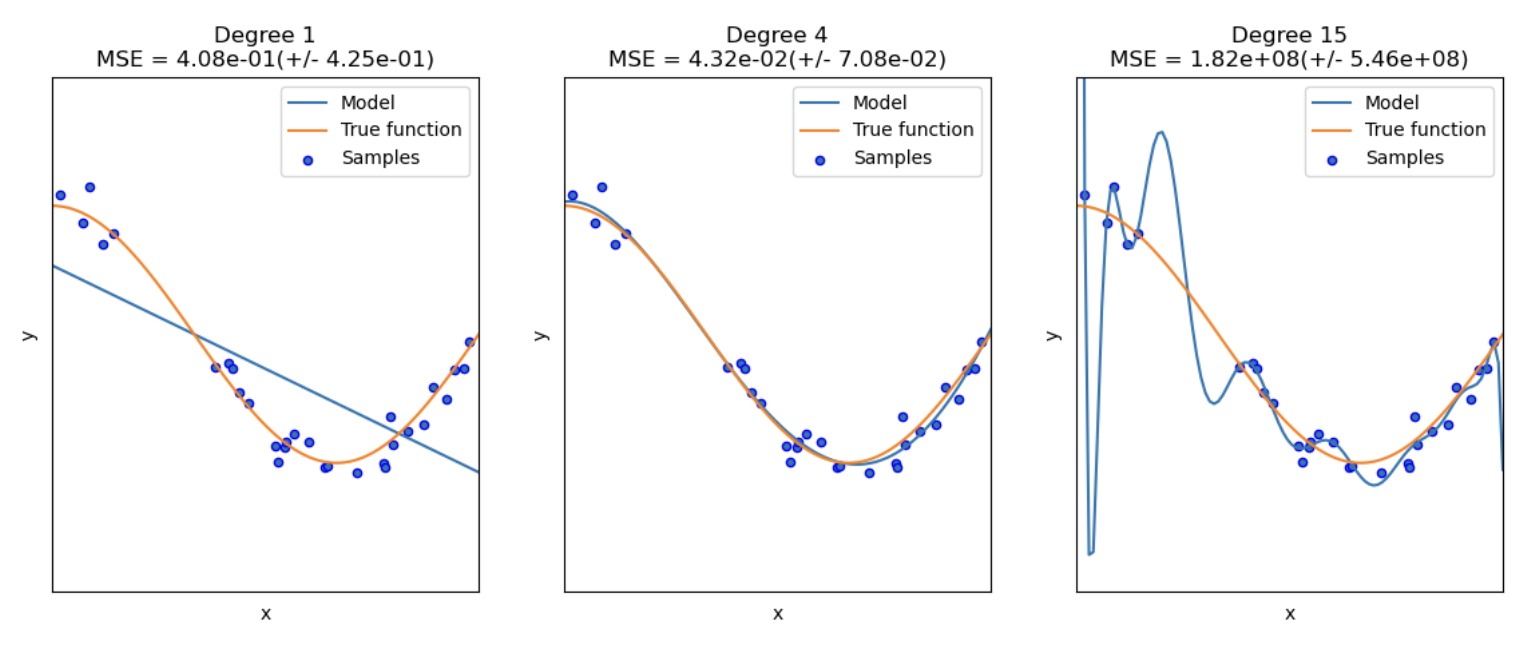

[Cross-validation](https://mlu-explain.github.io/cross-validation/) is a technique that can be used when there are multiple model parameters (aka hyperparameters) that could be tuned. In this case, our Elastic Net model has a few hyperparameters surrounding the way in which it selects feature sub-sets for the trained model to use (these are known as the `alpha` and `l1_ratio` parameters). **Cross validation** will take a sub-set of the training data and use it as intermediate test data to compare how the model performed using each combination of hyperparameters. This is repeated a number of times (in our case, five - in the case of the screenshot below, four), and the model with the best average score for each 'fold' is selected as the trained model.

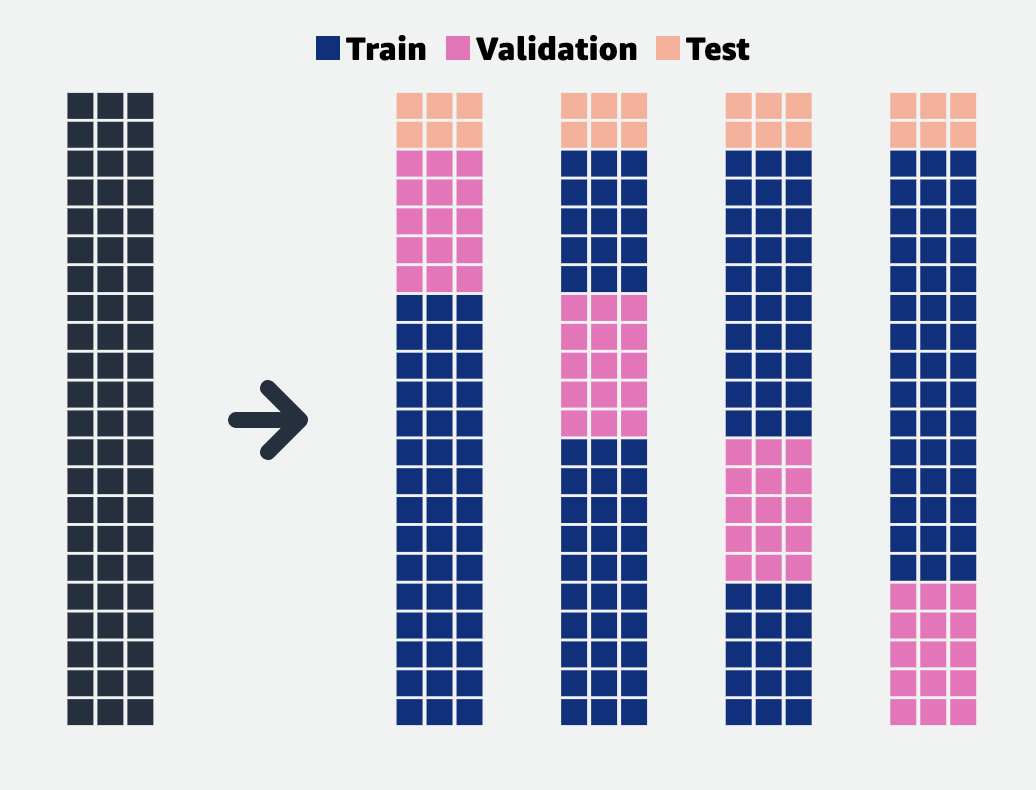

The benefit of using cross-validation is that we can select models with hyperparameters that statistically perform well over the training dataset without needing to test each outcome on our test dataset. This again ensures that we have **no leakage of information/insight** between the training and testing steps of model development.

In [ ]:
# possibly want a section discussing elastic net
# possibly want a section discussing cross-validation (briefly)
# go over the options for which features we want to train the model on. Create one model where we train on:
# 1. all of them (start with ONLY this, just to get something in place!!)
# 1. only a single feature
# 1. only non-correlated features

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


We will start by more explictly defining our training dataset

In [63]:
X_train = train_data.drop(columns = ['cyc_life','Dataset_group','log_cyc_life'])
y_train = train_data.log_cyc_life
X_train.head()

,min_deltaQ,mean_deltaQ,var_deltaQ,skew_deltaQ,kur_deltaQ,deltaQ_lowV,slope_22_99,intcpt_22_99,slope_90_99,intcpt_90_99,q_22,maxQ_q_22,q_99
Name,,,,,,,,,,,,,
2017-05-12_3_6C-80per_3_6C_CH2_VDF,-2.070144,-2.455492,-5.028018,-0.427786,-1.869674,-0.002186,-0.000017,1.082534,-0.000029,1.083580,1.081923,0.608978,1.080649
2017-05-12_4C-80per_4C_CH5_VDF,-1.840401,-2.218537,-4.632537,-0.526915,0.097271,-0.002521,-0.000007,1.085825,-0.000007,1.085408,1.085078,0.007000,1.084765
2017-05-12_4_4C-80per_4_4C_CH7_VDF,-1.657452,-2.032932,-4.293405,-0.725104,0.064739,-0.004419,-0.000011,1.081323,-0.000024,1.082180,1.080456,0.001615,1.079788
2017-05-12_4_8C-80per_4_8C_CH9_VDF,-1.547026,-1.950946,-4.041558,-0.335869,0.064054,-0.003491,-0.000024,1.098508,-0.000033,1.099141,1.096267,0.001701,1.095874
2017-05-12_5_4C-50per_3C_CH14_VDF,-1.589375,-2.030320,-4.108288,-0.228045,0.051376,-0.003403,-0.000008,1.061089,-0.000014,1.061318,1.060326,0.002914,1.059947


In [ ]:
# steps:
# 1. define x_train and y_train
# 1. initialize model with possible hyperparameters (do we want a pipeline that will SCALE the inputs?
# 1. train the model
# 1. look at feature importances, maybe look at best hyperparameters?
# 1. if I have time, select only a single feature and then train an separate model 
    # (OR SHOULD I DO THIS FIRST? THAT WAY I COULD SHOW THAT WE ARE REALLY JUST DOING LINEAR REGRESSION...??)

In [69]:
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]
pipe =  Pipeline([('scaler', StandardScaler()), ('enet', ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter = 25000))])
pipe.fit(np.array(X_train), np.ravel(y_train))

Pipeline(steps=[('scaler', StandardScaler()),
                ('enet',
                 ElasticNetCV(cv=5,
                              l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
                              max_iter=25000, random_state=0))])

In [71]:
predicted_train_cycle_life = pipe.predict(np.array(X_train))

In [83]:
train_mape = 100*mean_absolute_percentage_error(np.power(10, y_train), np.power(10, predicted_train_cycle_life))
train_rmse = mean_squared_error(np.power(10, y_train), np.power(10, predicted_train_cycle_life), squared=False)
print("Training mean absolute percentage error: ", train_mape, "%")
print("Training root mean squared error: ", train_rmse, " cycles")

Training mean absolute percentage error:  10.362722956698017 %
Training root mean squared error:  77.1418973585995  cycles


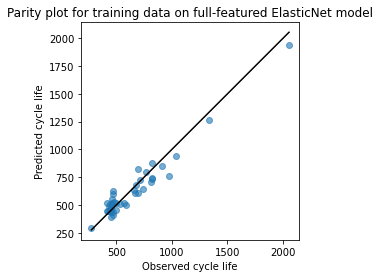

In [80]:
plt.scatter(10**y_train,10**predicted_train_cycle_life, alpha = 0.6)
min_axis = 10**min([min(y_train),min(predicted_train_cycle_life)])
max_axis = 10**max([max(y_train),max(predicted_train_cycle_life)])
plt.plot([min_axis,max_axis],[min_axis,max_axis],'k')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.title("Parity plot for training data on full-featured ElasticNet model")
plt.axis('square')
plt.show()

As a last step for our model training, let's take a look at the feature importances for this model. This will provide us with information on what input characteristics are most important to consider, and may help us tie the model performance back to underlying physical behaviors in the cells.

In [84]:
eNet_dchg_coef = pd.DataFrame()
eNet_dchg_coef['features'] = pipe.named_steps['enet'].coef_
eNet_dchg_coef['coef'] = X_train.columns
eNet_dchg_coef['abs_features'] = abs(eNet_dchg_coef['features'])
eNet_dchg_coef_sorted = eNet_dchg_coef.sort_values('abs_features',ascending=False)
eNet_dchg_coef_sorted.reset_index(inplace=True,drop=True)
eNet_dchg_coef_sorted.drop(columns=['abs_features'],inplace=True)

eNet_dchg_coef_sorted

,features,coef
0,-0.087075,mean_deltaQ
1,-0.058671,var_deltaQ
2,0.017622,intcpt_22_99
3,-0.010282,slope_22_99
4,-0.006508,kur_deltaQ
5,-0.000000,min_deltaQ
6,0.000000,skew_deltaQ
7,0.000000,deltaQ_lowV
8,-0.000000,slope_90_99
9,0.000000,intcpt_90_99


In [ ]:
# if I have time I can play around with smaller feature sets...

## Model Testing and Evaluation

## Prediction of Cycle Life on Unseen Data